In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from PIL import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
manifest=pd.read_csv('/kaggle/input/pokemon-images-and-types/pokemon.csv')
y=pd.get_dummies(manifest.Type1)
manifest=pd.concat([manifest['Name'].reset_index(drop=True), y], axis=1)
names=[]
index=0

for dirname, _, filenames in os.walk('/kaggle/input/pokemon-images-and-types/images/images/'):
    for filename in filenames:
        file_path_i = os.path.join(dirname, filename)
        name_i = filename.replace('.png','')
        names.append({'Name':name_i,'ix':index})
        if index==0:
            x=load_img(file_path_i)
            x=img_to_array(x)
            x.shape=(1,120,120,3)
            x=x/255.
        else:
            xi=load_img(file_path_i)
            xi=img_to_array(xi)
            xi.shape=(1,120,120,3)
            xi=xi/255.
            x = np.concatenate((x,xi),axis=0)
        index+=1
        #print(index)
names=pd.DataFrame(names)
manifest=manifest.merge(names,how='left')
dropme=np.where(manifest.ix.isna())
manifest.dropna(inplace=True)
manifest = manifest.set_index('ix',drop=True).sort_index()
x= np.delete(x,dropme,axis=0)
y=manifest.drop('Name',axis=1).values
x_train = np.float32(x)
x_test=x_train

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [4]:
x_train,x_test=x_train[:,:,:,0],x_train[:,:,:,0]

In [5]:
%matplotlib inline

In [6]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon




image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 5
epochs = 50000

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = Dense(intermediate_dim, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dense(intermediate_dim, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

data = (x_test, x_test)

# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 14400)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          7373312     encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          262656      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 512)          262656      dense_2[0][0]                    
____________________________________________________________________________________________

In [7]:
adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
vae.compile(optimizer=adam)
vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)


    # train the autoencoder
vae.fit(x_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')

/opt/conda/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 14400)             0         
_________________________________________________________________
encoder (Model)              [(None, 5), (None, 5), (N 8691722   
_________________________________________________________________
decoder (Model)              (None, 14400)             8703552   
Total params: 17,395,274
Trainable params: 17,395,274
Non-trainable params: 0
_________________________________________________________________
Train on 721 samples, validate on 721 samples
Epoch 1/100
721/721 [==============================] - 2s 2ms/step - loss: 9979.9587 - val_loss: 9978.1692
Epoch 2/100
721/721 [==============================] - 0s 195us/step - loss: 9976.8674 - val_loss: 9974.8045
Epoch 3/100
721/721 [==============================] - 0s 181us/step - loss: 9973.2880 - val_loss: 9970.7778
Epoch 

Epoch 69/100
721/721 [==============================] - 0s 181us/step - loss: 174.1414 - val_loss: 182.8365
Epoch 70/100
721/721 [==============================] - 0s 178us/step - loss: 209.2118 - val_loss: 189.0054
Epoch 71/100
721/721 [==============================] - 0s 181us/step - loss: 181.7564 - val_loss: 192.6638
Epoch 72/100
721/721 [==============================] - 0s 185us/step - loss: 182.0664 - val_loss: 178.8796
Epoch 73/100
721/721 [==============================] - 0s 199us/step - loss: 179.8699 - val_loss: 182.8617
Epoch 74/100
721/721 [==============================] - 0s 188us/step - loss: 177.2956 - val_loss: 181.0048
Epoch 75/100
721/721 [==============================] - 0s 182us/step - loss: 165.5302 - val_loss: 164.7407
Epoch 76/100
721/721 [==============================] - 0s 183us/step - loss: 158.3034 - val_loss: 160.6032
Epoch 77/100
721/721 [==============================] - 0s 195us/step - loss: 176.6831 - val_loss: 167.6916
Epoch 78/100
721/721 [======

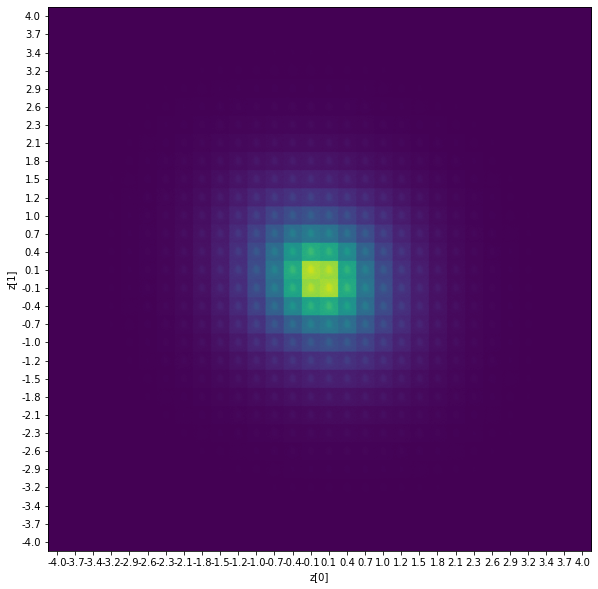

In [8]:
n = 30
digit_size = 120
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi,0,0,0]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = (n - 1) * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure)
plt.savefig(filename)
plt.show()

In [9]:
adam = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, amsgrad=False)
vae.compile(optimizer=adam)
vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)


    # train the autoencoder
vae.fit(x_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')

/opt/conda/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 14400)             0         
_________________________________________________________________
encoder (Model)              [(None, 5), (None, 5), (N 8691722   
_________________________________________________________________
decoder (Model)              (None, 14400)             8703552   
Total params: 17,395,274
Trainable params: 17,395,274
Non-trainable params: 0
_________________________________________________________________
Train on 721 samples, validate on 721 samples
Epoch 1/100
721/721 [==============================] - 1s 949us/step - loss: 129.0780 - val_loss: 128.8732
Epoch 2/100
721/721 [==============================] - 0s 186us/step - loss: 125.6782 - val_loss: 129.8039
Epoch 3/100
721/721 [==============================] - 0s 184us/step - loss: 124.1679 - val_loss: 126.3653
Epoch 4/10

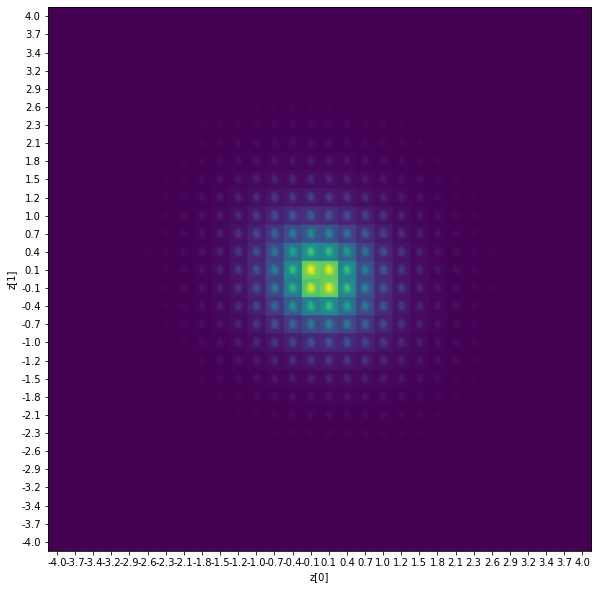

In [10]:
n = 30
digit_size = 120
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi,0,0,0]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = (n - 1) * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure)
plt.savefig(filename)
plt.show()

In [11]:
adam = Adam(lr=0.0000001, beta_1=0.9, beta_2=0.999, amsgrad=False)
vae.compile(optimizer=adam)
vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)


    # train the autoencoder
vae.fit(x_train,
        epochs=1000,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')

/opt/conda/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 14400)             0         
_________________________________________________________________
encoder (Model)              [(None, 5), (None, 5), (N 8691722   
_________________________________________________________________
decoder (Model)              (None, 14400)             8703552   
Total params: 17,395,274
Trainable params: 17,395,274
Non-trainable params: 0
_________________________________________________________________
Train on 721 samples, validate on 721 samples
Epoch 1/1000
721/721 [==============================] - 1s 978us/step - loss: 113.0128 - val_loss: 113.3507
Epoch 2/1000
721/721 [==============================] - 0s 183us/step - loss: 112.9212 - val_loss: 114.0153
Epoch 3/1000
721/721 [==============================] - 0s 205us/step - loss: 112.0091 - val_loss: 114.5953
Epoch 4

Epoch 69/1000
721/721 [==============================] - 0s 187us/step - loss: 111.9756 - val_loss: 111.1858
Epoch 70/1000
721/721 [==============================] - 0s 182us/step - loss: 117.8957 - val_loss: 119.3079
Epoch 71/1000
721/721 [==============================] - 0s 186us/step - loss: 117.1640 - val_loss: 118.4211
Epoch 72/1000
721/721 [==============================] - 0s 186us/step - loss: 115.3015 - val_loss: 114.7777
Epoch 73/1000
721/721 [==============================] - 0s 186us/step - loss: 117.4945 - val_loss: 119.5894
Epoch 74/1000
721/721 [==============================] - 0s 181us/step - loss: 117.3153 - val_loss: 117.0409
Epoch 75/1000
721/721 [==============================] - 0s 182us/step - loss: 114.0798 - val_loss: 110.4137
Epoch 76/1000
721/721 [==============================] - 0s 186us/step - loss: 112.4177 - val_loss: 113.5642
Epoch 77/1000
721/721 [==============================] - 0s 187us/step - loss: 115.3485 - val_loss: 114.3997
Epoch 78/1000
721/7

Epoch 144/1000
721/721 [==============================] - 0s 184us/step - loss: 110.4386 - val_loss: 111.0201
Epoch 145/1000
721/721 [==============================] - 0s 182us/step - loss: 115.0594 - val_loss: 116.7315
Epoch 146/1000
721/721 [==============================] - 0s 206us/step - loss: 112.7125 - val_loss: 110.1596
Epoch 147/1000
721/721 [==============================] - 0s 186us/step - loss: 113.4646 - val_loss: 113.4659
Epoch 148/1000
721/721 [==============================] - 0s 184us/step - loss: 116.3385 - val_loss: 114.8459
Epoch 149/1000
721/721 [==============================] - 0s 186us/step - loss: 114.7140 - val_loss: 116.5963
Epoch 150/1000
721/721 [==============================] - 0s 186us/step - loss: 109.2867 - val_loss: 108.5645
Epoch 151/1000
721/721 [==============================] - 0s 182us/step - loss: 107.9690 - val_loss: 109.2873
Epoch 152/1000
721/721 [==============================] - 0s 186us/step - loss: 113.3685 - val_loss: 114.1402
Epoch 153/

721/721 [==============================] - 0s 188us/step - loss: 125.1482 - val_loss: 120.1966
Epoch 293/1000
721/721 [==============================] - 0s 185us/step - loss: 110.3893 - val_loss: 110.2934
Epoch 294/1000
721/721 [==============================] - 0s 187us/step - loss: 109.9632 - val_loss: 111.8515
Epoch 295/1000
721/721 [==============================] - 0s 188us/step - loss: 118.5777 - val_loss: 114.6024
Epoch 296/1000
721/721 [==============================] - 0s 182us/step - loss: 115.4399 - val_loss: 113.4511
Epoch 297/1000
721/721 [==============================] - 0s 185us/step - loss: 112.6569 - val_loss: 113.7350
Epoch 298/1000
721/721 [==============================] - 0s 184us/step - loss: 110.1325 - val_loss: 109.9564
Epoch 299/1000
721/721 [==============================] - 0s 184us/step - loss: 120.0931 - val_loss: 119.5395
Epoch 300/1000
721/721 [==============================] - 0s 189us/step - loss: 113.9225 - val_loss: 110.4942
Epoch 301/1000
721/721 [=

721/721 [==============================] - 0s 187us/step - loss: 117.0585 - val_loss: 116.1598
Epoch 441/1000
721/721 [==============================] - 0s 183us/step - loss: 108.9717 - val_loss: 108.2469
Epoch 442/1000
721/721 [==============================] - 0s 198us/step - loss: 112.3965 - val_loss: 109.0057
Epoch 443/1000
721/721 [==============================] - 0s 183us/step - loss: 114.9100 - val_loss: 112.4171
Epoch 444/1000
721/721 [==============================] - 0s 206us/step - loss: 113.3916 - val_loss: 112.3109
Epoch 445/1000
721/721 [==============================] - 0s 221us/step - loss: 111.7088 - val_loss: 114.1736
Epoch 446/1000
721/721 [==============================] - 0s 209us/step - loss: 115.0689 - val_loss: 114.1864
Epoch 447/1000
721/721 [==============================] - 0s 218us/step - loss: 110.8895 - val_loss: 113.1822
Epoch 448/1000
721/721 [==============================] - 0s 199us/step - loss: 109.3269 - val_loss: 110.0830
Epoch 449/1000
721/721 [=

721/721 [==============================] - 0s 184us/step - loss: 111.8003 - val_loss: 112.6934
Epoch 589/1000
721/721 [==============================] - 0s 189us/step - loss: 115.3529 - val_loss: 109.6550
Epoch 590/1000
721/721 [==============================] - 0s 183us/step - loss: 113.5367 - val_loss: 114.5337
Epoch 591/1000
721/721 [==============================] - 0s 222us/step - loss: 113.9321 - val_loss: 114.7173
Epoch 592/1000
721/721 [==============================] - 0s 185us/step - loss: 113.8412 - val_loss: 114.6767
Epoch 593/1000
721/721 [==============================] - 0s 184us/step - loss: 110.5651 - val_loss: 109.6558
Epoch 594/1000
721/721 [==============================] - 0s 186us/step - loss: 113.4554 - val_loss: 114.6116
Epoch 595/1000
721/721 [==============================] - 0s 220us/step - loss: 109.1586 - val_loss: 111.8280
Epoch 596/1000
721/721 [==============================] - 0s 199us/step - loss: 112.2078 - val_loss: 111.6258
Epoch 597/1000
721/721 [=

721/721 [==============================] - 0s 215us/step - loss: 109.1639 - val_loss: 106.8414
Epoch 737/1000
721/721 [==============================] - 0s 186us/step - loss: 109.8063 - val_loss: 108.4684
Epoch 738/1000
721/721 [==============================] - 0s 201us/step - loss: 106.6031 - val_loss: 107.7266
Epoch 739/1000
721/721 [==============================] - 0s 202us/step - loss: 107.8341 - val_loss: 107.0442
Epoch 740/1000
721/721 [==============================] - 0s 199us/step - loss: 113.3107 - val_loss: 113.0545
Epoch 741/1000
721/721 [==============================] - 0s 196us/step - loss: 115.0376 - val_loss: 115.3387
Epoch 742/1000
721/721 [==============================] - 0s 195us/step - loss: 108.4625 - val_loss: 110.4854
Epoch 743/1000
721/721 [==============================] - 0s 193us/step - loss: 109.6783 - val_loss: 106.4197
Epoch 744/1000
721/721 [==============================] - 0s 195us/step - loss: 107.1372 - val_loss: 108.3081
Epoch 745/1000
721/721 [=

721/721 [==============================] - 0s 184us/step - loss: 113.2098 - val_loss: 115.6136
Epoch 885/1000
721/721 [==============================] - 0s 184us/step - loss: 109.9260 - val_loss: 108.6083
Epoch 886/1000
721/721 [==============================] - 0s 183us/step - loss: 111.2203 - val_loss: 108.4005
Epoch 887/1000
721/721 [==============================] - 0s 184us/step - loss: 115.3308 - val_loss: 113.7326
Epoch 888/1000
721/721 [==============================] - 0s 185us/step - loss: 110.8048 - val_loss: 110.6388
Epoch 889/1000
721/721 [==============================] - 0s 183us/step - loss: 111.4295 - val_loss: 111.2929
Epoch 890/1000
721/721 [==============================] - 0s 183us/step - loss: 110.6646 - val_loss: 111.3387
Epoch 891/1000
721/721 [==============================] - 0s 189us/step - loss: 107.7471 - val_loss: 105.6715
Epoch 892/1000
721/721 [==============================] - 0s 183us/step - loss: 105.4164 - val_loss: 107.3597
Epoch 893/1000
721/721 [=

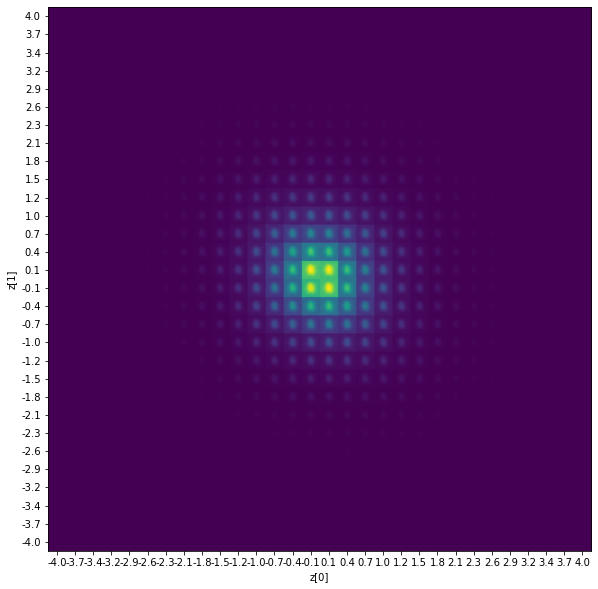

In [12]:
n = 30
digit_size = 120
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi,0,0,0]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = (n - 1) * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure)
plt.savefig(filename)
plt.show()

In [13]:
adam = Adam(lr=0.00000000001, beta_1=0.9, beta_2=0.999, amsgrad=False)
vae.compile(optimizer=adam)

vae.fit(x_train,
        epochs=1000,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')

/opt/conda/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 721 samples, validate on 721 samples
Epoch 1/1000
721/721 [==============================] - 1s 1ms/step - loss: 110.7465 - val_loss: 109.7793
Epoch 2/1000
721/721 [==============================] - 0s 194us/step - loss: 111.1444 - val_loss: 109.3140
Epoch 3/1000
721/721 [==============================] - 0s 188us/step - loss: 107.4055 - val_loss: 109.9749
Epoch 4/1000
721/721 [==============================] - 0s 220us/step - loss: 106.7203 - val_loss: 109.1092
Epoch 5/1000
721/721 [==============================] - 0s 195us/step - loss: 108.1639 - val_loss: 109.3793
Epoch 6/1000
721/721 [==============================] - 0s 187us/step - loss: 106.9609 - val_loss: 106.8757
Epoch 7/1000
721/721 [==============================] - 0s 194us/step - loss: 108.7075 - val_loss: 109.6600
Epoch 8/1000
721/721 [==============================] - 0s 191us/step - loss: 107.5580 - val_loss: 107.9051
Epoch 9/1000
721/721 [==============================] - 0s 194us/step - loss: 113.2422 - val

Epoch 76/1000
721/721 [==============================] - 0s 182us/step - loss: 110.9195 - val_loss: 109.7865
Epoch 77/1000
721/721 [==============================] - 0s 180us/step - loss: 109.1064 - val_loss: 110.0279
Epoch 78/1000
721/721 [==============================] - 0s 177us/step - loss: 117.8351 - val_loss: 113.6458
Epoch 79/1000
721/721 [==============================] - 0s 180us/step - loss: 109.6498 - val_loss: 112.0105
Epoch 80/1000
721/721 [==============================] - 0s 179us/step - loss: 111.1858 - val_loss: 111.9356
Epoch 81/1000
721/721 [==============================] - 0s 179us/step - loss: 105.8641 - val_loss: 105.8590
Epoch 82/1000
721/721 [==============================] - 0s 182us/step - loss: 114.5061 - val_loss: 117.2614
Epoch 83/1000
721/721 [==============================] - 0s 184us/step - loss: 109.2247 - val_loss: 110.9965
Epoch 84/1000
721/721 [==============================] - 0s 183us/step - loss: 114.2864 - val_loss: 115.4363
Epoch 85/1000
721/7

721/721 [==============================] - 0s 202us/step - loss: 110.9959 - val_loss: 108.2758
Epoch 225/1000
721/721 [==============================] - 0s 203us/step - loss: 110.3817 - val_loss: 108.7680
Epoch 226/1000
721/721 [==============================] - 0s 196us/step - loss: 114.9527 - val_loss: 110.1305
Epoch 227/1000
721/721 [==============================] - 0s 200us/step - loss: 114.6058 - val_loss: 118.1796
Epoch 228/1000
721/721 [==============================] - 0s 197us/step - loss: 108.7555 - val_loss: 106.8038
Epoch 229/1000
721/721 [==============================] - 0s 199us/step - loss: 112.5601 - val_loss: 112.7701
Epoch 230/1000
721/721 [==============================] - 0s 198us/step - loss: 105.6576 - val_loss: 108.3488
Epoch 231/1000
721/721 [==============================] - 0s 196us/step - loss: 112.2310 - val_loss: 110.1697
Epoch 232/1000
721/721 [==============================] - 0s 196us/step - loss: 112.7717 - val_loss: 110.6151
Epoch 233/1000
721/721 [=

721/721 [==============================] - 0s 178us/step - loss: 111.2157 - val_loss: 115.6800
Epoch 373/1000
721/721 [==============================] - 0s 346us/step - loss: 115.1469 - val_loss: 118.0307
Epoch 374/1000
721/721 [==============================] - 0s 210us/step - loss: 114.1858 - val_loss: 113.5567
Epoch 375/1000
721/721 [==============================] - 0s 207us/step - loss: 109.4767 - val_loss: 112.4388
Epoch 376/1000
721/721 [==============================] - 0s 211us/step - loss: 113.0608 - val_loss: 115.9160
Epoch 377/1000
721/721 [==============================] - 0s 205us/step - loss: 114.6206 - val_loss: 112.6071
Epoch 378/1000
721/721 [==============================] - 0s 185us/step - loss: 108.2661 - val_loss: 110.1183
Epoch 379/1000
721/721 [==============================] - 0s 186us/step - loss: 109.0818 - val_loss: 104.7604
Epoch 380/1000
721/721 [==============================] - 0s 181us/step - loss: 111.5555 - val_loss: 111.0237
Epoch 381/1000
721/721 [=

721/721 [==============================] - 0s 184us/step - loss: 109.6550 - val_loss: 109.0488
Epoch 521/1000
721/721 [==============================] - 0s 179us/step - loss: 113.1204 - val_loss: 112.7767
Epoch 522/1000
721/721 [==============================] - 0s 181us/step - loss: 111.4483 - val_loss: 112.0999
Epoch 523/1000
721/721 [==============================] - 0s 182us/step - loss: 106.3998 - val_loss: 106.0294
Epoch 524/1000
721/721 [==============================] - 0s 182us/step - loss: 110.5183 - val_loss: 110.5915
Epoch 525/1000
721/721 [==============================] - 0s 186us/step - loss: 109.6600 - val_loss: 109.2592
Epoch 526/1000
721/721 [==============================] - 0s 181us/step - loss: 109.7699 - val_loss: 108.1118
Epoch 527/1000
721/721 [==============================] - 0s 180us/step - loss: 107.2723 - val_loss: 106.7822
Epoch 528/1000
721/721 [==============================] - 0s 179us/step - loss: 112.2315 - val_loss: 115.7881
Epoch 529/1000
721/721 [=

721/721 [==============================] - 0s 193us/step - loss: 108.4226 - val_loss: 109.4237
Epoch 669/1000
721/721 [==============================] - 0s 198us/step - loss: 110.0273 - val_loss: 108.9844
Epoch 670/1000
721/721 [==============================] - 0s 193us/step - loss: 109.3455 - val_loss: 112.8336
Epoch 671/1000
721/721 [==============================] - 0s 204us/step - loss: 108.1060 - val_loss: 107.9266
Epoch 672/1000
721/721 [==============================] - 0s 190us/step - loss: 107.7286 - val_loss: 108.0509
Epoch 673/1000
721/721 [==============================] - 0s 180us/step - loss: 111.9669 - val_loss: 112.6832
Epoch 674/1000
721/721 [==============================] - 0s 183us/step - loss: 109.2945 - val_loss: 110.9751
Epoch 675/1000
721/721 [==============================] - 0s 182us/step - loss: 117.2224 - val_loss: 112.1233
Epoch 676/1000
721/721 [==============================] - 0s 179us/step - loss: 110.1626 - val_loss: 113.3056
Epoch 677/1000
721/721 [=

721/721 [==============================] - 0s 229us/step - loss: 118.0047 - val_loss: 118.2272
Epoch 817/1000
721/721 [==============================] - 0s 215us/step - loss: 110.9459 - val_loss: 112.6225
Epoch 818/1000
721/721 [==============================] - 0s 201us/step - loss: 108.5943 - val_loss: 106.3083
Epoch 819/1000
721/721 [==============================] - 0s 216us/step - loss: 109.8107 - val_loss: 111.1048
Epoch 820/1000
721/721 [==============================] - 0s 196us/step - loss: 108.4715 - val_loss: 111.9653
Epoch 821/1000
721/721 [==============================] - 0s 193us/step - loss: 113.5146 - val_loss: 111.9160
Epoch 822/1000
721/721 [==============================] - 0s 206us/step - loss: 110.3697 - val_loss: 107.0065
Epoch 823/1000
721/721 [==============================] - 0s 207us/step - loss: 114.8755 - val_loss: 113.1103
Epoch 824/1000
721/721 [==============================] - 0s 181us/step - loss: 110.9651 - val_loss: 114.3167
Epoch 825/1000
721/721 [=

721/721 [==============================] - 0s 183us/step - loss: 112.4271 - val_loss: 109.6939
Epoch 965/1000
721/721 [==============================] - 0s 180us/step - loss: 112.3547 - val_loss: 109.7435
Epoch 966/1000
721/721 [==============================] - 0s 179us/step - loss: 116.0430 - val_loss: 113.2464
Epoch 967/1000
721/721 [==============================] - 0s 182us/step - loss: 115.4847 - val_loss: 115.8012
Epoch 968/1000
721/721 [==============================] - 0s 190us/step - loss: 109.1083 - val_loss: 110.3618
Epoch 969/1000
721/721 [==============================] - 0s 180us/step - loss: 108.2918 - val_loss: 108.6416
Epoch 970/1000
721/721 [==============================] - 0s 179us/step - loss: 103.4680 - val_loss: 103.1393
Epoch 971/1000
721/721 [==============================] - 0s 181us/step - loss: 107.9180 - val_loss: 108.0930
Epoch 972/1000
721/721 [==============================] - 0s 183us/step - loss: 110.4674 - val_loss: 109.3241
Epoch 973/1000
721/721 [=

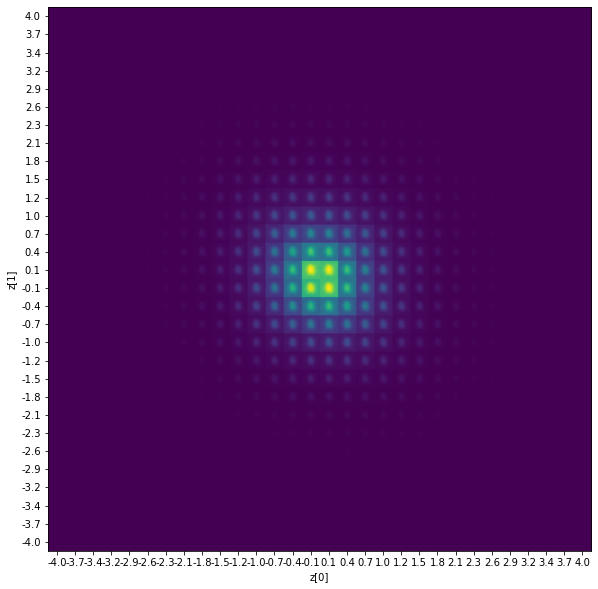

In [14]:
n = 30
digit_size = 120
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi,0,0,0]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = (n - 1) * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure)
plt.savefig(filename)
plt.show()

In [15]:
adam = Adam(lr=1e-30, beta_1=0.9, beta_2=0.999, amsgrad=False)
vae.compile(optimizer=adam)

vae.fit(x_train,
        epochs=5000,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 721 samples, validate on 721 samples
Epoch 1/5000
721/721 [==============================] - 1s 1ms/step - loss: 107.6757 - val_loss: 109.7793
Epoch 2/5000
721/721 [==============================] - 0s 216us/step - loss: 112.9569 - val_loss: 109.3140
Epoch 3/5000
721/721 [==============================] - 0s 189us/step - loss: 107.3469 - val_loss: 109.9749
Epoch 4/5000
721/721 [==============================] - 0s 192us/step - loss: 105.9505 - val_loss: 109.1091
Epoch 5/5000
721/721 [==============================] - 0s 190us/step - loss: 108.4177 - val_loss: 109.3794
Epoch 6/5000
721/721 [==============================] - 0s 195us/step - loss: 104.9517 - val_loss: 106.8757
Epoch 7/5000
721/721 [==============================] - 0s 185us/step - loss: 108.6077 - val_loss: 109.6600
Epoch 8/5000
721/721 [==============================] - 0s 183us/step - loss: 111.1306 - val_loss: 107.9051
Epoch 9/5000
721/721 [==============================] - 0s 181us/step - loss: 111.4917 - val

Epoch 76/5000
721/721 [==============================] - 0s 208us/step - loss: 109.4034 - val_loss: 109.7865
Epoch 77/5000
721/721 [==============================] - 0s 198us/step - loss: 111.9403 - val_loss: 110.0279
Epoch 78/5000
721/721 [==============================] - 0s 198us/step - loss: 111.6111 - val_loss: 113.6458
Epoch 79/5000
721/721 [==============================] - 0s 197us/step - loss: 111.8001 - val_loss: 112.0105
Epoch 80/5000
721/721 [==============================] - 0s 194us/step - loss: 110.2127 - val_loss: 111.9356
Epoch 81/5000
721/721 [==============================] - 0s 201us/step - loss: 107.6544 - val_loss: 105.8590
Epoch 82/5000
721/721 [==============================] - 0s 199us/step - loss: 112.9652 - val_loss: 117.2614
Epoch 83/5000
721/721 [==============================] - 0s 201us/step - loss: 108.7895 - val_loss: 110.9965
Epoch 84/5000
721/721 [==============================] - 0s 207us/step - loss: 113.5966 - val_loss: 115.4363
Epoch 85/5000
721/7

721/721 [==============================] - 0s 189us/step - loss: 107.9322 - val_loss: 108.2758
Epoch 225/5000
721/721 [==============================] - 0s 182us/step - loss: 109.7940 - val_loss: 108.7680
Epoch 226/5000
721/721 [==============================] - 0s 182us/step - loss: 109.7112 - val_loss: 110.1305
Epoch 227/5000
721/721 [==============================] - 0s 182us/step - loss: 116.0689 - val_loss: 118.1796
Epoch 228/5000
721/721 [==============================] - 0s 186us/step - loss: 107.2111 - val_loss: 106.8038
Epoch 229/5000
721/721 [==============================] - 0s 183us/step - loss: 112.7821 - val_loss: 112.7701
Epoch 230/5000
721/721 [==============================] - 0s 189us/step - loss: 107.9462 - val_loss: 108.3488
Epoch 231/5000
721/721 [==============================] - 0s 211us/step - loss: 110.5947 - val_loss: 110.1697
Epoch 232/5000
721/721 [==============================] - 0s 200us/step - loss: 108.1181 - val_loss: 110.6151
Epoch 233/5000
721/721 [=

721/721 [==============================] - 0s 183us/step - loss: 111.8559 - val_loss: 115.6800
Epoch 373/5000
721/721 [==============================] - 0s 186us/step - loss: 114.3543 - val_loss: 118.0307
Epoch 374/5000
721/721 [==============================] - 0s 182us/step - loss: 109.6970 - val_loss: 113.5567
Epoch 375/5000
721/721 [==============================] - 0s 181us/step - loss: 111.1763 - val_loss: 112.4388
Epoch 376/5000
721/721 [==============================] - 0s 186us/step - loss: 113.3238 - val_loss: 115.9160
Epoch 377/5000
721/721 [==============================] - 0s 183us/step - loss: 110.7042 - val_loss: 112.6071
Epoch 378/5000
721/721 [==============================] - 0s 181us/step - loss: 109.2369 - val_loss: 110.1183
Epoch 379/5000
721/721 [==============================] - 0s 187us/step - loss: 106.3768 - val_loss: 104.7604
Epoch 380/5000
721/721 [==============================] - 0s 182us/step - loss: 112.1261 - val_loss: 111.0237
Epoch 381/5000
721/721 [=

721/721 [==============================] - 0s 180us/step - loss: 107.5886 - val_loss: 109.0488
Epoch 521/5000
721/721 [==============================] - 0s 187us/step - loss: 110.7907 - val_loss: 112.7767
Epoch 522/5000
721/721 [==============================] - 0s 188us/step - loss: 112.7634 - val_loss: 112.0999
Epoch 523/5000
721/721 [==============================] - 0s 183us/step - loss: 105.3688 - val_loss: 106.0294
Epoch 524/5000
721/721 [==============================] - 0s 184us/step - loss: 108.4184 - val_loss: 110.5915
Epoch 525/5000
721/721 [==============================] - 0s 187us/step - loss: 108.6275 - val_loss: 109.2592
Epoch 526/5000
721/721 [==============================] - 0s 183us/step - loss: 108.1323 - val_loss: 108.1118
Epoch 527/5000
721/721 [==============================] - 0s 182us/step - loss: 106.8924 - val_loss: 106.7822
Epoch 528/5000
721/721 [==============================] - 0s 191us/step - loss: 115.4900 - val_loss: 115.7881
Epoch 529/5000
721/721 [=

721/721 [==============================] - 0s 212us/step - loss: 109.7594 - val_loss: 109.4237
Epoch 669/5000
721/721 [==============================] - 0s 198us/step - loss: 108.8204 - val_loss: 108.9844
Epoch 670/5000
721/721 [==============================] - 0s 183us/step - loss: 110.9776 - val_loss: 112.8336
Epoch 671/5000
721/721 [==============================] - 0s 184us/step - loss: 108.1083 - val_loss: 107.9266
Epoch 672/5000
721/721 [==============================] - 0s 185us/step - loss: 109.1019 - val_loss: 108.0509
Epoch 673/5000
721/721 [==============================] - 0s 187us/step - loss: 110.1496 - val_loss: 112.6832
Epoch 674/5000
721/721 [==============================] - 0s 182us/step - loss: 108.6410 - val_loss: 110.9751
Epoch 675/5000
721/721 [==============================] - 0s 187us/step - loss: 115.9060 - val_loss: 112.1233
Epoch 676/5000
721/721 [==============================] - 0s 187us/step - loss: 112.9480 - val_loss: 113.3056
Epoch 677/5000
721/721 [=

721/721 [==============================] - 0s 187us/step - loss: 116.2458 - val_loss: 118.2272
Epoch 817/5000
721/721 [==============================] - 0s 180us/step - loss: 111.9896 - val_loss: 112.6225
Epoch 818/5000
721/721 [==============================] - 0s 204us/step - loss: 107.0668 - val_loss: 106.3083
Epoch 819/5000
721/721 [==============================] - 0s 198us/step - loss: 115.1991 - val_loss: 111.1048
Epoch 820/5000
721/721 [==============================] - 0s 202us/step - loss: 111.5123 - val_loss: 111.9653
Epoch 821/5000
721/721 [==============================] - 0s 206us/step - loss: 111.1085 - val_loss: 111.9160
Epoch 822/5000
721/721 [==============================] - 0s 182us/step - loss: 110.5061 - val_loss: 107.0065
Epoch 823/5000
721/721 [==============================] - 0s 184us/step - loss: 111.8851 - val_loss: 113.1103
Epoch 824/5000
721/721 [==============================] - 0s 180us/step - loss: 112.4564 - val_loss: 114.3167
Epoch 825/5000
721/721 [=

721/721 [==============================] - 0s 185us/step - loss: 110.2914 - val_loss: 109.6939
Epoch 965/5000
721/721 [==============================] - 0s 189us/step - loss: 109.4856 - val_loss: 109.7435
Epoch 966/5000
721/721 [==============================] - 0s 187us/step - loss: 114.6452 - val_loss: 113.2464
Epoch 967/5000
721/721 [==============================] - 0s 188us/step - loss: 113.8895 - val_loss: 115.8012
Epoch 968/5000
721/721 [==============================] - 0s 190us/step - loss: 109.7943 - val_loss: 110.3618
Epoch 969/5000
721/721 [==============================] - 0s 196us/step - loss: 107.1954 - val_loss: 108.6416
Epoch 970/5000
721/721 [==============================] - 0s 188us/step - loss: 106.8693 - val_loss: 103.1393
Epoch 971/5000
721/721 [==============================] - 0s 189us/step - loss: 107.5069 - val_loss: 108.0930
Epoch 972/5000
721/721 [==============================] - 0s 189us/step - loss: 107.9021 - val_loss: 109.3241
Epoch 973/5000
721/721 [=

Epoch 1112/5000
721/721 [==============================] - 0s 183us/step - loss: 110.4586 - val_loss: 112.8665
Epoch 1113/5000
721/721 [==============================] - 0s 183us/step - loss: 107.6284 - val_loss: 110.3600
Epoch 1114/5000
721/721 [==============================] - 0s 183us/step - loss: 111.6662 - val_loss: 108.7538
Epoch 1115/5000
721/721 [==============================] - 0s 183us/step - loss: 111.0811 - val_loss: 111.8672
Epoch 1116/5000
721/721 [==============================] - 0s 181us/step - loss: 112.3168 - val_loss: 116.0473
Epoch 1117/5000
721/721 [==============================] - 0s 182us/step - loss: 110.2497 - val_loss: 111.7591
Epoch 1118/5000
721/721 [==============================] - 0s 202us/step - loss: 112.2488 - val_loss: 110.2909
Epoch 1119/5000
721/721 [==============================] - 0s 189us/step - loss: 111.8929 - val_loss: 109.3497
Epoch 1120/5000
721/721 [==============================] - 0s 184us/step - loss: 107.6087 - val_loss: 106.7757
E

Epoch 1186/5000
721/721 [==============================] - 0s 188us/step - loss: 112.7515 - val_loss: 112.0278
Epoch 1187/5000
721/721 [==============================] - 0s 182us/step - loss: 109.0615 - val_loss: 108.7257
Epoch 1188/5000
721/721 [==============================] - 0s 187us/step - loss: 113.3518 - val_loss: 111.8089
Epoch 1189/5000
721/721 [==============================] - 0s 190us/step - loss: 111.2817 - val_loss: 108.1467
Epoch 1190/5000
721/721 [==============================] - 0s 188us/step - loss: 105.1528 - val_loss: 108.0787
Epoch 1191/5000
721/721 [==============================] - 0s 184us/step - loss: 109.6871 - val_loss: 108.0984
Epoch 1192/5000
721/721 [==============================] - 0s 183us/step - loss: 107.6316 - val_loss: 107.5174
Epoch 1193/5000
721/721 [==============================] - 0s 184us/step - loss: 108.9499 - val_loss: 108.0566
Epoch 1194/5000
721/721 [==============================] - 0s 184us/step - loss: 110.0327 - val_loss: 108.3532
E

Epoch 1260/5000
721/721 [==============================] - 0s 181us/step - loss: 111.0817 - val_loss: 113.5772
Epoch 1261/5000
721/721 [==============================] - 0s 186us/step - loss: 117.9463 - val_loss: 114.9473
Epoch 1262/5000
721/721 [==============================] - 0s 184us/step - loss: 110.8326 - val_loss: 109.9435
Epoch 1263/5000
721/721 [==============================] - 0s 182us/step - loss: 113.1732 - val_loss: 111.2556
Epoch 1264/5000
721/721 [==============================] - 0s 182us/step - loss: 116.2403 - val_loss: 111.1193
Epoch 1265/5000
721/721 [==============================] - 0s 189us/step - loss: 112.7629 - val_loss: 110.3422
Epoch 1266/5000
721/721 [==============================] - 0s 183us/step - loss: 111.8934 - val_loss: 115.1515
Epoch 1267/5000
721/721 [==============================] - 0s 182us/step - loss: 106.9567 - val_loss: 108.4845
Epoch 1268/5000
721/721 [==============================] - 0s 187us/step - loss: 109.6265 - val_loss: 110.8003
E

Epoch 1334/5000
721/721 [==============================] - 0s 181us/step - loss: 111.3096 - val_loss: 108.7555
Epoch 1335/5000
721/721 [==============================] - 0s 183us/step - loss: 110.5867 - val_loss: 109.8582
Epoch 1336/5000
721/721 [==============================] - 0s 182us/step - loss: 110.3924 - val_loss: 110.6296
Epoch 1337/5000
721/721 [==============================] - 0s 185us/step - loss: 112.7103 - val_loss: 115.1799
Epoch 1338/5000
721/721 [==============================] - 0s 188us/step - loss: 108.9385 - val_loss: 111.8077
Epoch 1339/5000
721/721 [==============================] - 0s 187us/step - loss: 112.6801 - val_loss: 111.3903
Epoch 1340/5000
721/721 [==============================] - 0s 182us/step - loss: 108.9800 - val_loss: 107.9238
Epoch 1341/5000
721/721 [==============================] - 0s 185us/step - loss: 107.1968 - val_loss: 107.9288
Epoch 1342/5000
721/721 [==============================] - 0s 184us/step - loss: 112.8545 - val_loss: 114.1660
E

Epoch 1408/5000
721/721 [==============================] - 0s 183us/step - loss: 110.4247 - val_loss: 105.1812
Epoch 1409/5000
721/721 [==============================] - 0s 184us/step - loss: 111.2260 - val_loss: 112.0314
Epoch 1410/5000
721/721 [==============================] - 0s 188us/step - loss: 109.1746 - val_loss: 109.8534
Epoch 1411/5000
721/721 [==============================] - 0s 186us/step - loss: 111.2565 - val_loss: 109.4984
Epoch 1412/5000
721/721 [==============================] - 0s 180us/step - loss: 112.4196 - val_loss: 111.2997
Epoch 1413/5000
721/721 [==============================] - 0s 182us/step - loss: 107.8722 - val_loss: 107.5923
Epoch 1414/5000
721/721 [==============================] - 0s 182us/step - loss: 112.4710 - val_loss: 110.7235
Epoch 1415/5000
721/721 [==============================] - 0s 182us/step - loss: 116.6200 - val_loss: 117.5048
Epoch 1416/5000
721/721 [==============================] - 0s 183us/step - loss: 107.9020 - val_loss: 107.6900
E

Epoch 1482/5000
721/721 [==============================] - 0s 180us/step - loss: 110.9370 - val_loss: 114.8579
Epoch 1483/5000
721/721 [==============================] - 0s 186us/step - loss: 110.8379 - val_loss: 109.6048
Epoch 1484/5000
721/721 [==============================] - 0s 192us/step - loss: 114.5849 - val_loss: 112.4903
Epoch 1485/5000
721/721 [==============================] - 0s 183us/step - loss: 106.7353 - val_loss: 109.1740
Epoch 1486/5000
721/721 [==============================] - 0s 181us/step - loss: 106.2738 - val_loss: 107.3175
Epoch 1487/5000
721/721 [==============================] - 0s 180us/step - loss: 111.0433 - val_loss: 113.5013
Epoch 1488/5000
721/721 [==============================] - 0s 183us/step - loss: 109.6260 - val_loss: 110.3611
Epoch 1489/5000
721/721 [==============================] - 0s 183us/step - loss: 106.1102 - val_loss: 103.7116
Epoch 1490/5000
721/721 [==============================] - 0s 187us/step - loss: 110.3693 - val_loss: 110.1400
E

Epoch 1556/5000
721/721 [==============================] - 0s 182us/step - loss: 107.5353 - val_loss: 111.1111
Epoch 1557/5000
721/721 [==============================] - 0s 180us/step - loss: 109.3711 - val_loss: 109.5081
Epoch 1558/5000
721/721 [==============================] - 0s 187us/step - loss: 110.3198 - val_loss: 109.7528
Epoch 1559/5000
721/721 [==============================] - 0s 184us/step - loss: 109.8454 - val_loss: 108.1311
Epoch 1560/5000
721/721 [==============================] - 0s 180us/step - loss: 108.6131 - val_loss: 111.7432
Epoch 1561/5000
721/721 [==============================] - 0s 183us/step - loss: 109.9335 - val_loss: 111.1328
Epoch 1562/5000
721/721 [==============================] - 0s 186us/step - loss: 111.2943 - val_loss: 109.1285
Epoch 1563/5000
721/721 [==============================] - 0s 189us/step - loss: 108.5418 - val_loss: 111.5966
Epoch 1564/5000
721/721 [==============================] - 0s 185us/step - loss: 108.9835 - val_loss: 106.6319
E

Epoch 1630/5000
721/721 [==============================] - 0s 184us/step - loss: 114.7598 - val_loss: 114.3173
Epoch 1631/5000
721/721 [==============================] - 0s 184us/step - loss: 110.2991 - val_loss: 107.3351
Epoch 1632/5000
721/721 [==============================] - 0s 186us/step - loss: 106.6105 - val_loss: 106.8818
Epoch 1633/5000
721/721 [==============================] - 0s 183us/step - loss: 113.7673 - val_loss: 112.5479
Epoch 1634/5000
721/721 [==============================] - 0s 184us/step - loss: 111.9102 - val_loss: 114.2994
Epoch 1635/5000
721/721 [==============================] - 0s 184us/step - loss: 115.0051 - val_loss: 113.7619
Epoch 1636/5000
721/721 [==============================] - 0s 183us/step - loss: 112.3747 - val_loss: 110.9720
Epoch 1637/5000
721/721 [==============================] - 0s 182us/step - loss: 108.9114 - val_loss: 110.3485
Epoch 1638/5000
721/721 [==============================] - 0s 181us/step - loss: 116.8369 - val_loss: 113.3086
E

Epoch 1704/5000
721/721 [==============================] - 0s 194us/step - loss: 106.3853 - val_loss: 107.6502
Epoch 1705/5000
721/721 [==============================] - 0s 183us/step - loss: 105.8759 - val_loss: 107.4365
Epoch 1706/5000
721/721 [==============================] - 0s 184us/step - loss: 108.1396 - val_loss: 109.0383
Epoch 1707/5000
721/721 [==============================] - 0s 183us/step - loss: 109.1610 - val_loss: 107.7706
Epoch 1708/5000
721/721 [==============================] - 0s 186us/step - loss: 108.1098 - val_loss: 108.8637
Epoch 1709/5000
721/721 [==============================] - 0s 184us/step - loss: 110.1559 - val_loss: 107.7158
Epoch 1710/5000
721/721 [==============================] - 0s 181us/step - loss: 110.0958 - val_loss: 108.1632
Epoch 1711/5000
721/721 [==============================] - 0s 182us/step - loss: 108.6477 - val_loss: 110.5276
Epoch 1712/5000
721/721 [==============================] - 0s 187us/step - loss: 108.2113 - val_loss: 107.7600
E

Epoch 1778/5000
721/721 [==============================] - 0s 206us/step - loss: 113.0533 - val_loss: 111.7529
Epoch 1779/5000
721/721 [==============================] - 0s 216us/step - loss: 111.1725 - val_loss: 110.5700
Epoch 1780/5000
721/721 [==============================] - 0s 192us/step - loss: 112.4775 - val_loss: 111.3678
Epoch 1781/5000
721/721 [==============================] - 0s 198us/step - loss: 108.1771 - val_loss: 108.3651
Epoch 1782/5000
721/721 [==============================] - 0s 198us/step - loss: 106.5433 - val_loss: 107.5686
Epoch 1783/5000
721/721 [==============================] - 0s 197us/step - loss: 111.9628 - val_loss: 108.4947
Epoch 1784/5000
721/721 [==============================] - 0s 205us/step - loss: 109.3012 - val_loss: 112.1074
Epoch 1785/5000
721/721 [==============================] - 0s 200us/step - loss: 112.1148 - val_loss: 113.8306
Epoch 1786/5000
721/721 [==============================] - 0s 190us/step - loss: 113.6906 - val_loss: 112.0364
E

Epoch 1852/5000
721/721 [==============================] - 0s 185us/step - loss: 107.6484 - val_loss: 109.1209
Epoch 1853/5000
721/721 [==============================] - 0s 181us/step - loss: 110.6949 - val_loss: 108.8251
Epoch 1854/5000
721/721 [==============================] - 0s 193us/step - loss: 105.3608 - val_loss: 106.9359
Epoch 1855/5000
721/721 [==============================] - 0s 201us/step - loss: 112.9128 - val_loss: 107.9609
Epoch 1856/5000
721/721 [==============================] - 0s 191us/step - loss: 109.6692 - val_loss: 111.8806
Epoch 1857/5000
721/721 [==============================] - 0s 217us/step - loss: 105.7350 - val_loss: 105.1961
Epoch 1858/5000
721/721 [==============================] - 0s 190us/step - loss: 106.2535 - val_loss: 106.6740
Epoch 1859/5000
721/721 [==============================] - 0s 221us/step - loss: 108.7249 - val_loss: 110.4169
Epoch 1860/5000
721/721 [==============================] - 0s 185us/step - loss: 114.3008 - val_loss: 114.1161
E

Epoch 1926/5000
721/721 [==============================] - 0s 187us/step - loss: 110.2207 - val_loss: 111.0214
Epoch 1927/5000
721/721 [==============================] - 0s 190us/step - loss: 111.7179 - val_loss: 114.0060
Epoch 1928/5000
721/721 [==============================] - 0s 209us/step - loss: 111.0007 - val_loss: 110.5731
Epoch 1929/5000
721/721 [==============================] - 0s 182us/step - loss: 104.9573 - val_loss: 105.5044
Epoch 1930/5000
721/721 [==============================] - 0s 187us/step - loss: 111.3323 - val_loss: 110.0121
Epoch 1931/5000
721/721 [==============================] - 0s 185us/step - loss: 109.8018 - val_loss: 109.0107
Epoch 1932/5000
721/721 [==============================] - 0s 181us/step - loss: 112.9755 - val_loss: 112.0386
Epoch 1933/5000
721/721 [==============================] - 0s 180us/step - loss: 108.9620 - val_loss: 111.1503
Epoch 1934/5000
721/721 [==============================] - 0s 388us/step - loss: 108.9449 - val_loss: 109.7625
E

Epoch 2000/5000
721/721 [==============================] - 0s 184us/step - loss: 112.2676 - val_loss: 112.2824
Epoch 2001/5000
721/721 [==============================] - 0s 183us/step - loss: 111.7957 - val_loss: 109.1322
Epoch 2002/5000
721/721 [==============================] - 0s 221us/step - loss: 112.0893 - val_loss: 114.0343
Epoch 2003/5000
721/721 [==============================] - 0s 186us/step - loss: 113.4798 - val_loss: 113.8151
Epoch 2004/5000
721/721 [==============================] - 0s 188us/step - loss: 108.8847 - val_loss: 107.8085
Epoch 2005/5000
721/721 [==============================] - 0s 182us/step - loss: 110.0572 - val_loss: 108.8282
Epoch 2006/5000
721/721 [==============================] - 0s 219us/step - loss: 115.1678 - val_loss: 112.9977
Epoch 2007/5000
721/721 [==============================] - 0s 186us/step - loss: 112.6571 - val_loss: 112.5992
Epoch 2008/5000
721/721 [==============================] - 0s 182us/step - loss: 109.3369 - val_loss: 109.0401
E

Epoch 2074/5000
721/721 [==============================] - 0s 201us/step - loss: 105.3057 - val_loss: 111.8770
Epoch 2075/5000
721/721 [==============================] - 0s 209us/step - loss: 107.5613 - val_loss: 108.1551
Epoch 2076/5000
721/721 [==============================] - 0s 200us/step - loss: 112.1017 - val_loss: 110.7130
Epoch 2077/5000
721/721 [==============================] - 0s 197us/step - loss: 107.0809 - val_loss: 110.2513
Epoch 2078/5000
721/721 [==============================] - 0s 195us/step - loss: 113.5932 - val_loss: 115.3015
Epoch 2079/5000
721/721 [==============================] - 0s 201us/step - loss: 108.5575 - val_loss: 109.2536
Epoch 2080/5000
721/721 [==============================] - 0s 196us/step - loss: 110.7637 - val_loss: 107.8192
Epoch 2081/5000
721/721 [==============================] - 0s 200us/step - loss: 107.3228 - val_loss: 107.9958
Epoch 2082/5000
721/721 [==============================] - 0s 195us/step - loss: 114.6227 - val_loss: 112.6274
E

Epoch 2148/5000
721/721 [==============================] - 0s 184us/step - loss: 107.0173 - val_loss: 106.9893
Epoch 2149/5000
721/721 [==============================] - 0s 184us/step - loss: 104.5844 - val_loss: 104.7013
Epoch 2150/5000
721/721 [==============================] - 0s 186us/step - loss: 112.1815 - val_loss: 112.2421
Epoch 2151/5000
721/721 [==============================] - 0s 182us/step - loss: 109.7651 - val_loss: 109.5352
Epoch 2152/5000
721/721 [==============================] - 0s 183us/step - loss: 109.1499 - val_loss: 110.3273
Epoch 2153/5000
721/721 [==============================] - 0s 183us/step - loss: 108.4102 - val_loss: 107.5957
Epoch 2154/5000
721/721 [==============================] - 0s 183us/step - loss: 108.8575 - val_loss: 110.6788
Epoch 2155/5000
721/721 [==============================] - 0s 188us/step - loss: 108.4555 - val_loss: 105.9142
Epoch 2156/5000
721/721 [==============================] - 0s 183us/step - loss: 108.4689 - val_loss: 110.0540
E

Epoch 2222/5000
721/721 [==============================] - 0s 185us/step - loss: 111.4751 - val_loss: 110.3935
Epoch 2223/5000
721/721 [==============================] - 0s 179us/step - loss: 113.2639 - val_loss: 114.7473
Epoch 2224/5000
721/721 [==============================] - 0s 183us/step - loss: 113.7585 - val_loss: 112.0020
Epoch 2225/5000
721/721 [==============================] - 0s 180us/step - loss: 111.2457 - val_loss: 112.1073
Epoch 2226/5000
721/721 [==============================] - 0s 184us/step - loss: 109.0859 - val_loss: 108.2495
Epoch 2227/5000
721/721 [==============================] - 0s 183us/step - loss: 114.3630 - val_loss: 113.2209
Epoch 2228/5000
721/721 [==============================] - 0s 183us/step - loss: 109.2020 - val_loss: 112.6969
Epoch 2229/5000
721/721 [==============================] - 0s 184us/step - loss: 111.7582 - val_loss: 110.4445
Epoch 2230/5000
721/721 [==============================] - 0s 183us/step - loss: 106.2487 - val_loss: 105.3795
E

Epoch 2296/5000
721/721 [==============================] - 0s 189us/step - loss: 109.5520 - val_loss: 107.1503
Epoch 2297/5000
721/721 [==============================] - 0s 182us/step - loss: 106.9200 - val_loss: 104.8724
Epoch 2298/5000
721/721 [==============================] - 0s 187us/step - loss: 109.5736 - val_loss: 107.7758
Epoch 2299/5000
721/721 [==============================] - 0s 182us/step - loss: 111.7827 - val_loss: 111.2861
Epoch 2300/5000
721/721 [==============================] - 0s 184us/step - loss: 113.0560 - val_loss: 113.0827
Epoch 2301/5000
721/721 [==============================] - 0s 181us/step - loss: 115.1295 - val_loss: 119.7838
Epoch 2302/5000
721/721 [==============================] - 0s 183us/step - loss: 117.0157 - val_loss: 115.5144
Epoch 2303/5000
721/721 [==============================] - 0s 180us/step - loss: 112.0620 - val_loss: 113.5615
Epoch 2304/5000
721/721 [==============================] - 0s 184us/step - loss: 106.9622 - val_loss: 109.7316
E

Epoch 2370/5000
721/721 [==============================] - 0s 213us/step - loss: 112.9234 - val_loss: 113.2782
Epoch 2371/5000
721/721 [==============================] - 0s 188us/step - loss: 105.2929 - val_loss: 106.5575
Epoch 2372/5000
721/721 [==============================] - 0s 185us/step - loss: 108.9883 - val_loss: 110.7346
Epoch 2373/5000
721/721 [==============================] - 0s 182us/step - loss: 109.9811 - val_loss: 112.8019
Epoch 2374/5000
721/721 [==============================] - 0s 187us/step - loss: 107.5666 - val_loss: 108.1493
Epoch 2375/5000
721/721 [==============================] - 0s 195us/step - loss: 113.6683 - val_loss: 110.3864
Epoch 2376/5000
721/721 [==============================] - 0s 182us/step - loss: 114.2194 - val_loss: 114.0633
Epoch 2377/5000
721/721 [==============================] - 0s 206us/step - loss: 109.8679 - val_loss: 110.6101
Epoch 2378/5000
721/721 [==============================] - 0s 181us/step - loss: 115.2426 - val_loss: 113.6076
E

Epoch 2444/5000
721/721 [==============================] - 0s 180us/step - loss: 108.8521 - val_loss: 108.8777
Epoch 2445/5000
721/721 [==============================] - 0s 182us/step - loss: 108.9031 - val_loss: 109.6125
Epoch 2446/5000
721/721 [==============================] - 0s 180us/step - loss: 107.8047 - val_loss: 109.1175
Epoch 2447/5000
721/721 [==============================] - 0s 180us/step - loss: 109.3558 - val_loss: 107.0226
Epoch 2448/5000
721/721 [==============================] - 0s 185us/step - loss: 114.1000 - val_loss: 119.2472
Epoch 2449/5000
721/721 [==============================] - 0s 187us/step - loss: 110.0748 - val_loss: 109.0500
Epoch 2450/5000
721/721 [==============================] - 0s 191us/step - loss: 107.9300 - val_loss: 108.8820
Epoch 2451/5000
721/721 [==============================] - 0s 188us/step - loss: 112.6927 - val_loss: 113.8819
Epoch 2452/5000
721/721 [==============================] - 0s 183us/step - loss: 108.2020 - val_loss: 107.9377
E

Epoch 2518/5000
721/721 [==============================] - 0s 182us/step - loss: 108.9927 - val_loss: 107.9878
Epoch 2519/5000
721/721 [==============================] - 0s 184us/step - loss: 109.4359 - val_loss: 107.8694
Epoch 2520/5000
721/721 [==============================] - 0s 190us/step - loss: 109.9932 - val_loss: 111.9632
Epoch 2521/5000
721/721 [==============================] - 0s 181us/step - loss: 112.7167 - val_loss: 110.8486
Epoch 2522/5000
721/721 [==============================] - 0s 184us/step - loss: 109.6886 - val_loss: 107.7863
Epoch 2523/5000
721/721 [==============================] - 0s 190us/step - loss: 108.4472 - val_loss: 109.2182
Epoch 2524/5000
721/721 [==============================] - 0s 185us/step - loss: 111.9567 - val_loss: 109.3402
Epoch 2525/5000
721/721 [==============================] - 0s 184us/step - loss: 108.9058 - val_loss: 107.4316
Epoch 2526/5000
721/721 [==============================] - 0s 184us/step - loss: 110.2969 - val_loss: 109.8945
E

Epoch 2592/5000
721/721 [==============================] - 0s 184us/step - loss: 106.2283 - val_loss: 108.9747
Epoch 2593/5000
721/721 [==============================] - 0s 184us/step - loss: 110.5185 - val_loss: 113.5011
Epoch 2594/5000
721/721 [==============================] - 0s 182us/step - loss: 108.6223 - val_loss: 107.4239
Epoch 2595/5000
721/721 [==============================] - 0s 186us/step - loss: 114.5372 - val_loss: 109.2860
Epoch 2596/5000
721/721 [==============================] - 0s 225us/step - loss: 108.3822 - val_loss: 106.5015
Epoch 2597/5000
721/721 [==============================] - 0s 186us/step - loss: 113.4716 - val_loss: 110.0388
Epoch 2598/5000
721/721 [==============================] - 0s 183us/step - loss: 111.4328 - val_loss: 111.2239
Epoch 2599/5000
721/721 [==============================] - 0s 191us/step - loss: 114.0000 - val_loss: 110.8883
Epoch 2600/5000
721/721 [==============================] - 0s 230us/step - loss: 112.0224 - val_loss: 110.0218
E

Epoch 2666/5000
721/721 [==============================] - 0s 181us/step - loss: 106.5585 - val_loss: 106.7657
Epoch 2667/5000
721/721 [==============================] - 0s 182us/step - loss: 108.5356 - val_loss: 112.3660
Epoch 2668/5000
721/721 [==============================] - 0s 180us/step - loss: 111.0111 - val_loss: 112.8124
Epoch 2669/5000
721/721 [==============================] - 0s 194us/step - loss: 107.9700 - val_loss: 110.2849
Epoch 2670/5000
721/721 [==============================] - 0s 181us/step - loss: 107.7951 - val_loss: 106.7142
Epoch 2671/5000
721/721 [==============================] - 0s 184us/step - loss: 107.0164 - val_loss: 109.1859
Epoch 2672/5000
721/721 [==============================] - 0s 182us/step - loss: 114.5817 - val_loss: 114.2750
Epoch 2673/5000
721/721 [==============================] - 0s 187us/step - loss: 110.6779 - val_loss: 110.0801
Epoch 2674/5000
721/721 [==============================] - 0s 182us/step - loss: 109.5239 - val_loss: 108.5101
E

Epoch 2740/5000
721/721 [==============================] - 0s 181us/step - loss: 111.9703 - val_loss: 113.0177
Epoch 2741/5000
721/721 [==============================] - 0s 183us/step - loss: 104.2977 - val_loss: 107.2998
Epoch 2742/5000
721/721 [==============================] - 0s 193us/step - loss: 110.5045 - val_loss: 110.5855
Epoch 2743/5000
721/721 [==============================] - 0s 186us/step - loss: 106.5835 - val_loss: 106.9657
Epoch 2744/5000
721/721 [==============================] - 0s 185us/step - loss: 107.5328 - val_loss: 107.6771
Epoch 2745/5000
721/721 [==============================] - 0s 184us/step - loss: 107.0085 - val_loss: 105.9590
Epoch 2746/5000
721/721 [==============================] - 0s 185us/step - loss: 107.3860 - val_loss: 106.7784
Epoch 2747/5000
721/721 [==============================] - 0s 182us/step - loss: 107.8433 - val_loss: 109.9964
Epoch 2748/5000
721/721 [==============================] - 0s 184us/step - loss: 111.6775 - val_loss: 112.4427
E

Epoch 2814/5000
721/721 [==============================] - 0s 199us/step - loss: 111.4491 - val_loss: 109.8206
Epoch 2815/5000
721/721 [==============================] - 0s 213us/step - loss: 109.0022 - val_loss: 111.0320
Epoch 2816/5000
721/721 [==============================] - 0s 199us/step - loss: 112.3818 - val_loss: 111.5437
Epoch 2817/5000
721/721 [==============================] - 0s 201us/step - loss: 111.3719 - val_loss: 111.5777
Epoch 2818/5000
721/721 [==============================] - 0s 201us/step - loss: 111.2565 - val_loss: 108.3493
Epoch 2819/5000
721/721 [==============================] - 0s 201us/step - loss: 110.0436 - val_loss: 111.3798
Epoch 2820/5000
721/721 [==============================] - 0s 198us/step - loss: 111.5499 - val_loss: 115.9866
Epoch 2821/5000
721/721 [==============================] - 0s 195us/step - loss: 110.9568 - val_loss: 107.8247
Epoch 2822/5000
721/721 [==============================] - 0s 190us/step - loss: 106.5681 - val_loss: 109.2282
E

Epoch 2888/5000
721/721 [==============================] - 0s 197us/step - loss: 111.6577 - val_loss: 112.7595
Epoch 2889/5000
721/721 [==============================] - 0s 186us/step - loss: 109.2448 - val_loss: 111.3435
Epoch 2890/5000
721/721 [==============================] - 0s 200us/step - loss: 108.1657 - val_loss: 108.5641
Epoch 2891/5000
721/721 [==============================] - 0s 185us/step - loss: 109.1568 - val_loss: 111.9361
Epoch 2892/5000
721/721 [==============================] - 0s 181us/step - loss: 113.0256 - val_loss: 112.6356
Epoch 2893/5000
721/721 [==============================] - 0s 187us/step - loss: 107.7279 - val_loss: 107.2380
Epoch 2894/5000
721/721 [==============================] - 0s 182us/step - loss: 111.8994 - val_loss: 112.7881
Epoch 2895/5000
721/721 [==============================] - 0s 186us/step - loss: 110.6089 - val_loss: 112.6393
Epoch 2896/5000
721/721 [==============================] - 0s 183us/step - loss: 108.2552 - val_loss: 110.3090
E

Epoch 2962/5000
721/721 [==============================] - 0s 188us/step - loss: 113.2031 - val_loss: 109.6081
Epoch 2963/5000
721/721 [==============================] - 0s 183us/step - loss: 107.2872 - val_loss: 107.8010
Epoch 2964/5000
721/721 [==============================] - 0s 188us/step - loss: 107.3241 - val_loss: 108.6860
Epoch 2965/5000
721/721 [==============================] - 0s 179us/step - loss: 110.4973 - val_loss: 110.3259
Epoch 2966/5000
721/721 [==============================] - 0s 224us/step - loss: 109.0589 - val_loss: 107.2177
Epoch 2967/5000
721/721 [==============================] - 0s 193us/step - loss: 110.0507 - val_loss: 106.7347
Epoch 2968/5000
721/721 [==============================] - 0s 191us/step - loss: 109.2992 - val_loss: 107.1073
Epoch 2969/5000
721/721 [==============================] - 0s 202us/step - loss: 113.2431 - val_loss: 113.7162
Epoch 2970/5000
721/721 [==============================] - 0s 182us/step - loss: 105.9591 - val_loss: 109.6618
E

Epoch 3036/5000
721/721 [==============================] - 0s 199us/step - loss: 110.3347 - val_loss: 109.5310
Epoch 3037/5000
721/721 [==============================] - 0s 185us/step - loss: 110.6904 - val_loss: 109.8509
Epoch 3038/5000
721/721 [==============================] - 0s 181us/step - loss: 109.4870 - val_loss: 107.1279
Epoch 3039/5000
721/721 [==============================] - 0s 188us/step - loss: 113.4298 - val_loss: 114.6858
Epoch 3040/5000
721/721 [==============================] - 0s 185us/step - loss: 109.0611 - val_loss: 109.2050
Epoch 3041/5000
721/721 [==============================] - 0s 186us/step - loss: 109.2233 - val_loss: 108.8380
Epoch 3042/5000
721/721 [==============================] - 0s 208us/step - loss: 111.8983 - val_loss: 112.8085
Epoch 3043/5000
721/721 [==============================] - 0s 181us/step - loss: 108.0109 - val_loss: 105.9689
Epoch 3044/5000
721/721 [==============================] - 0s 182us/step - loss: 113.3284 - val_loss: 110.1333
E

Epoch 3110/5000
721/721 [==============================] - 0s 186us/step - loss: 105.2043 - val_loss: 107.1392
Epoch 3111/5000
721/721 [==============================] - 0s 183us/step - loss: 113.0802 - val_loss: 112.2553
Epoch 3112/5000
721/721 [==============================] - 0s 181us/step - loss: 111.6087 - val_loss: 109.3293
Epoch 3113/5000
721/721 [==============================] - 0s 178us/step - loss: 114.6075 - val_loss: 112.9454
Epoch 3114/5000
721/721 [==============================] - 0s 182us/step - loss: 108.1211 - val_loss: 107.7721
Epoch 3115/5000
721/721 [==============================] - 0s 185us/step - loss: 112.3078 - val_loss: 114.0484
Epoch 3116/5000
721/721 [==============================] - 0s 186us/step - loss: 110.4993 - val_loss: 112.8516
Epoch 3117/5000
721/721 [==============================] - 0s 194us/step - loss: 108.4086 - val_loss: 111.4765
Epoch 3118/5000
721/721 [==============================] - 0s 189us/step - loss: 108.2572 - val_loss: 106.8422
E

Epoch 3184/5000
721/721 [==============================] - 0s 182us/step - loss: 109.3632 - val_loss: 110.7674
Epoch 3185/5000
721/721 [==============================] - 0s 187us/step - loss: 112.3195 - val_loss: 110.9250
Epoch 3186/5000
721/721 [==============================] - 0s 198us/step - loss: 113.1122 - val_loss: 115.9705
Epoch 3187/5000
721/721 [==============================] - 0s 190us/step - loss: 108.5263 - val_loss: 109.1643
Epoch 3188/5000
721/721 [==============================] - 0s 187us/step - loss: 112.7219 - val_loss: 113.4645
Epoch 3189/5000
721/721 [==============================] - 0s 186us/step - loss: 106.4952 - val_loss: 107.2023
Epoch 3190/5000
721/721 [==============================] - 0s 188us/step - loss: 107.7815 - val_loss: 107.2490
Epoch 3191/5000
721/721 [==============================] - 0s 186us/step - loss: 111.6781 - val_loss: 111.6142
Epoch 3192/5000
721/721 [==============================] - 0s 186us/step - loss: 115.6112 - val_loss: 110.2398
E

Epoch 3258/5000
721/721 [==============================] - 0s 182us/step - loss: 107.8698 - val_loss: 106.0331
Epoch 3259/5000
721/721 [==============================] - 0s 181us/step - loss: 112.1881 - val_loss: 112.6985
Epoch 3260/5000
721/721 [==============================] - 0s 200us/step - loss: 111.1890 - val_loss: 108.0122
Epoch 3261/5000
721/721 [==============================] - 0s 186us/step - loss: 109.2971 - val_loss: 110.6449
Epoch 3262/5000
721/721 [==============================] - 0s 188us/step - loss: 107.2764 - val_loss: 108.9627
Epoch 3263/5000
721/721 [==============================] - 0s 180us/step - loss: 108.9707 - val_loss: 109.9789
Epoch 3264/5000
721/721 [==============================] - 0s 183us/step - loss: 114.0727 - val_loss: 115.1783
Epoch 3265/5000
721/721 [==============================] - 0s 183us/step - loss: 110.3464 - val_loss: 109.7701
Epoch 3266/5000
721/721 [==============================] - 0s 188us/step - loss: 109.8962 - val_loss: 109.2297
E

Epoch 3332/5000
721/721 [==============================] - 0s 186us/step - loss: 110.3115 - val_loss: 112.2769
Epoch 3333/5000
721/721 [==============================] - 0s 183us/step - loss: 111.1737 - val_loss: 113.7479
Epoch 3334/5000
721/721 [==============================] - 0s 183us/step - loss: 109.0181 - val_loss: 109.7693
Epoch 3335/5000
721/721 [==============================] - 0s 190us/step - loss: 112.4045 - val_loss: 114.5397
Epoch 3336/5000
721/721 [==============================] - 0s 181us/step - loss: 110.4901 - val_loss: 111.7655
Epoch 3337/5000
721/721 [==============================] - 0s 182us/step - loss: 113.5536 - val_loss: 109.9194
Epoch 3338/5000
721/721 [==============================] - 0s 183us/step - loss: 113.5637 - val_loss: 111.8535
Epoch 3339/5000
721/721 [==============================] - 0s 186us/step - loss: 112.1276 - val_loss: 112.4191
Epoch 3340/5000
721/721 [==============================] - 0s 184us/step - loss: 113.1679 - val_loss: 114.2522
E

Epoch 3406/5000
721/721 [==============================] - 0s 194us/step - loss: 109.8067 - val_loss: 105.3223
Epoch 3407/5000
721/721 [==============================] - 0s 202us/step - loss: 111.3913 - val_loss: 114.3325
Epoch 3408/5000
721/721 [==============================] - 0s 196us/step - loss: 108.1536 - val_loss: 105.5981
Epoch 3409/5000
721/721 [==============================] - 0s 196us/step - loss: 112.8044 - val_loss: 111.2138
Epoch 3410/5000
721/721 [==============================] - 0s 198us/step - loss: 110.7320 - val_loss: 112.4193
Epoch 3411/5000
721/721 [==============================] - 0s 195us/step - loss: 111.3843 - val_loss: 111.6947
Epoch 3412/5000
721/721 [==============================] - 0s 190us/step - loss: 112.2649 - val_loss: 108.8507
Epoch 3413/5000
721/721 [==============================] - 0s 189us/step - loss: 110.1879 - val_loss: 110.1708
Epoch 3414/5000
721/721 [==============================] - 0s 186us/step - loss: 109.6231 - val_loss: 109.6522
E

Epoch 3480/5000
721/721 [==============================] - 0s 200us/step - loss: 107.0826 - val_loss: 106.1314
Epoch 3481/5000
721/721 [==============================] - 0s 198us/step - loss: 111.7835 - val_loss: 111.1652
Epoch 3482/5000
721/721 [==============================] - 0s 199us/step - loss: 109.2817 - val_loss: 108.8158
Epoch 3483/5000
721/721 [==============================] - 0s 188us/step - loss: 112.4974 - val_loss: 110.8415
Epoch 3484/5000
721/721 [==============================] - 0s 188us/step - loss: 109.9306 - val_loss: 110.0404
Epoch 3485/5000
721/721 [==============================] - 0s 184us/step - loss: 108.3378 - val_loss: 109.8051
Epoch 3486/5000
721/721 [==============================] - 0s 183us/step - loss: 109.7319 - val_loss: 109.8700
Epoch 3487/5000
721/721 [==============================] - 0s 183us/step - loss: 106.7180 - val_loss: 108.0084
Epoch 3488/5000
721/721 [==============================] - 0s 182us/step - loss: 113.1356 - val_loss: 113.2517
E

Epoch 3554/5000
721/721 [==============================] - 0s 181us/step - loss: 113.4222 - val_loss: 111.7482
Epoch 3555/5000
721/721 [==============================] - 0s 182us/step - loss: 107.6969 - val_loss: 109.8820
Epoch 3556/5000
721/721 [==============================] - 0s 184us/step - loss: 111.9142 - val_loss: 107.3982
Epoch 3557/5000
721/721 [==============================] - 0s 187us/step - loss: 110.3077 - val_loss: 110.1417
Epoch 3558/5000
721/721 [==============================] - 0s 182us/step - loss: 119.7447 - val_loss: 112.5686
Epoch 3559/5000
721/721 [==============================] - 0s 185us/step - loss: 110.9583 - val_loss: 111.4801
Epoch 3560/5000
721/721 [==============================] - 0s 188us/step - loss: 112.6365 - val_loss: 114.7171
Epoch 3561/5000
721/721 [==============================] - 0s 181us/step - loss: 106.9640 - val_loss: 110.6719
Epoch 3562/5000
721/721 [==============================] - 0s 186us/step - loss: 111.7072 - val_loss: 108.6605
E

Epoch 3628/5000
721/721 [==============================] - 0s 184us/step - loss: 109.7521 - val_loss: 109.6194
Epoch 3629/5000
721/721 [==============================] - 0s 186us/step - loss: 105.1545 - val_loss: 108.4968
Epoch 3630/5000
721/721 [==============================] - 0s 183us/step - loss: 109.3056 - val_loss: 110.9370
Epoch 3631/5000
721/721 [==============================] - 0s 184us/step - loss: 114.0928 - val_loss: 109.9857
Epoch 3632/5000
721/721 [==============================] - 0s 185us/step - loss: 109.6854 - val_loss: 108.1204
Epoch 3633/5000
721/721 [==============================] - 0s 180us/step - loss: 114.6165 - val_loss: 115.6372
Epoch 3634/5000
721/721 [==============================] - 0s 180us/step - loss: 107.6952 - val_loss: 110.3678
Epoch 3635/5000
721/721 [==============================] - 0s 179us/step - loss: 106.3778 - val_loss: 107.0924
Epoch 3636/5000
721/721 [==============================] - 0s 185us/step - loss: 112.6263 - val_loss: 114.4496
E

Epoch 3702/5000
721/721 [==============================] - 0s 216us/step - loss: 112.0532 - val_loss: 110.0739
Epoch 3703/5000
721/721 [==============================] - 0s 214us/step - loss: 110.5665 - val_loss: 109.9776
Epoch 3704/5000
721/721 [==============================] - 0s 210us/step - loss: 109.2231 - val_loss: 110.8448
Epoch 3705/5000
721/721 [==============================] - 0s 215us/step - loss: 105.9568 - val_loss: 107.0164
Epoch 3706/5000
721/721 [==============================] - 0s 228us/step - loss: 106.6562 - val_loss: 109.1271
Epoch 3707/5000
721/721 [==============================] - 0s 182us/step - loss: 109.0283 - val_loss: 109.1088
Epoch 3708/5000
721/721 [==============================] - 0s 182us/step - loss: 114.5532 - val_loss: 110.1128
Epoch 3709/5000
721/721 [==============================] - 0s 186us/step - loss: 110.8290 - val_loss: 109.7979
Epoch 3710/5000
721/721 [==============================] - 0s 181us/step - loss: 114.5290 - val_loss: 112.6440
E

Epoch 3776/5000
721/721 [==============================] - 0s 201us/step - loss: 102.5048 - val_loss: 105.3671
Epoch 3777/5000
721/721 [==============================] - 0s 198us/step - loss: 110.5078 - val_loss: 109.6756
Epoch 3778/5000
721/721 [==============================] - 0s 198us/step - loss: 108.9774 - val_loss: 108.6084
Epoch 3779/5000
721/721 [==============================] - 0s 192us/step - loss: 108.5551 - val_loss: 108.9187
Epoch 3780/5000
721/721 [==============================] - 0s 194us/step - loss: 112.2063 - val_loss: 108.1150
Epoch 3781/5000
721/721 [==============================] - 0s 207us/step - loss: 111.9371 - val_loss: 110.7675
Epoch 3782/5000
721/721 [==============================] - 0s 182us/step - loss: 110.7003 - val_loss: 110.1246
Epoch 3783/5000
721/721 [==============================] - 0s 182us/step - loss: 109.9419 - val_loss: 111.1919
Epoch 3784/5000
721/721 [==============================] - 0s 187us/step - loss: 112.7406 - val_loss: 111.7033
E

Epoch 3850/5000
721/721 [==============================] - 0s 184us/step - loss: 109.6751 - val_loss: 111.6773
Epoch 3851/5000
721/721 [==============================] - 0s 184us/step - loss: 116.5565 - val_loss: 116.4884
Epoch 3852/5000
721/721 [==============================] - 0s 180us/step - loss: 116.9542 - val_loss: 113.7544
Epoch 3853/5000
721/721 [==============================] - 0s 183us/step - loss: 110.2723 - val_loss: 109.5304
Epoch 3854/5000
721/721 [==============================] - 0s 182us/step - loss: 110.5937 - val_loss: 108.1282
Epoch 3855/5000
721/721 [==============================] - 0s 185us/step - loss: 110.0033 - val_loss: 110.5417
Epoch 3856/5000
721/721 [==============================] - 0s 186us/step - loss: 107.9349 - val_loss: 109.3036
Epoch 3857/5000
721/721 [==============================] - 0s 185us/step - loss: 109.2874 - val_loss: 103.6656
Epoch 3858/5000
721/721 [==============================] - 0s 182us/step - loss: 109.1028 - val_loss: 110.4859
E

Epoch 3924/5000
721/721 [==============================] - 0s 190us/step - loss: 106.9858 - val_loss: 105.8104
Epoch 3925/5000
721/721 [==============================] - 0s 184us/step - loss: 108.3710 - val_loss: 108.3119
Epoch 3926/5000
721/721 [==============================] - 0s 184us/step - loss: 114.5023 - val_loss: 112.7587
Epoch 3927/5000
721/721 [==============================] - 0s 182us/step - loss: 108.1374 - val_loss: 111.0724
Epoch 3928/5000
721/721 [==============================] - 0s 181us/step - loss: 108.7350 - val_loss: 105.6106
Epoch 3929/5000
721/721 [==============================] - 0s 186us/step - loss: 110.2849 - val_loss: 110.6532
Epoch 3930/5000
721/721 [==============================] - 0s 190us/step - loss: 110.8986 - val_loss: 109.1668
Epoch 3931/5000
721/721 [==============================] - 0s 184us/step - loss: 108.2952 - val_loss: 109.6597
Epoch 3932/5000
721/721 [==============================] - 0s 183us/step - loss: 111.5768 - val_loss: 110.8511
E

Epoch 3998/5000
721/721 [==============================] - 0s 194us/step - loss: 106.4758 - val_loss: 107.2509
Epoch 3999/5000
721/721 [==============================] - 0s 206us/step - loss: 115.1849 - val_loss: 113.4760
Epoch 4000/5000
721/721 [==============================] - 0s 205us/step - loss: 111.4245 - val_loss: 112.4865
Epoch 4001/5000
721/721 [==============================] - 0s 207us/step - loss: 109.4900 - val_loss: 109.1924
Epoch 4002/5000
721/721 [==============================] - 0s 188us/step - loss: 107.1364 - val_loss: 107.0249
Epoch 4003/5000
721/721 [==============================] - 0s 183us/step - loss: 110.6492 - val_loss: 111.7995
Epoch 4004/5000
721/721 [==============================] - 0s 182us/step - loss: 111.0786 - val_loss: 109.9890
Epoch 4005/5000
721/721 [==============================] - 0s 184us/step - loss: 112.6241 - val_loss: 116.6696
Epoch 4006/5000
721/721 [==============================] - 0s 191us/step - loss: 113.7539 - val_loss: 109.9171
E

Epoch 4072/5000
721/721 [==============================] - 0s 183us/step - loss: 113.9221 - val_loss: 117.2224
Epoch 4073/5000
721/721 [==============================] - 0s 189us/step - loss: 109.6736 - val_loss: 110.8921
Epoch 4074/5000
721/721 [==============================] - 0s 189us/step - loss: 113.9884 - val_loss: 112.7989
Epoch 4075/5000
721/721 [==============================] - 0s 186us/step - loss: 113.8920 - val_loss: 113.1169
Epoch 4076/5000
721/721 [==============================] - 0s 195us/step - loss: 112.1321 - val_loss: 112.7280
Epoch 4077/5000
721/721 [==============================] - 0s 212us/step - loss: 112.7957 - val_loss: 112.3290
Epoch 4078/5000
721/721 [==============================] - 0s 205us/step - loss: 110.1540 - val_loss: 111.3312
Epoch 4079/5000
721/721 [==============================] - 0s 211us/step - loss: 114.9541 - val_loss: 112.6732
Epoch 4080/5000
721/721 [==============================] - 0s 193us/step - loss: 107.0226 - val_loss: 105.4237
E

Epoch 4146/5000
721/721 [==============================] - 0s 186us/step - loss: 110.8284 - val_loss: 112.1674
Epoch 4147/5000
721/721 [==============================] - 0s 185us/step - loss: 110.6393 - val_loss: 110.8430
Epoch 4148/5000
721/721 [==============================] - 0s 181us/step - loss: 105.8518 - val_loss: 107.1415
Epoch 4149/5000
721/721 [==============================] - 0s 216us/step - loss: 113.9107 - val_loss: 114.4984
Epoch 4150/5000
721/721 [==============================] - 0s 189us/step - loss: 112.4228 - val_loss: 107.5834
Epoch 4151/5000
721/721 [==============================] - 0s 184us/step - loss: 107.7989 - val_loss: 107.6952
Epoch 4152/5000
721/721 [==============================] - 0s 235us/step - loss: 110.1919 - val_loss: 107.8530
Epoch 4153/5000
721/721 [==============================] - 0s 183us/step - loss: 110.5824 - val_loss: 109.3446
Epoch 4154/5000
721/721 [==============================] - 0s 184us/step - loss: 105.3457 - val_loss: 104.3696
E

Epoch 4220/5000
721/721 [==============================] - 0s 182us/step - loss: 108.0061 - val_loss: 107.6902
Epoch 4221/5000
721/721 [==============================] - 0s 203us/step - loss: 105.8546 - val_loss: 107.0281
Epoch 4222/5000
721/721 [==============================] - 0s 200us/step - loss: 111.9478 - val_loss: 111.4074
Epoch 4223/5000
721/721 [==============================] - 0s 182us/step - loss: 112.5961 - val_loss: 113.8521
Epoch 4224/5000
721/721 [==============================] - 0s 184us/step - loss: 110.3181 - val_loss: 111.7590
Epoch 4225/5000
721/721 [==============================] - 0s 184us/step - loss: 113.2970 - val_loss: 112.9258
Epoch 4226/5000
721/721 [==============================] - 0s 184us/step - loss: 112.8203 - val_loss: 112.1140
Epoch 4227/5000
721/721 [==============================] - 0s 192us/step - loss: 112.6429 - val_loss: 114.7675
Epoch 4228/5000
721/721 [==============================] - 0s 204us/step - loss: 107.3052 - val_loss: 112.5673
E

Epoch 4294/5000
721/721 [==============================] - 0s 186us/step - loss: 106.8443 - val_loss: 110.3224
Epoch 4295/5000
721/721 [==============================] - 0s 181us/step - loss: 110.5027 - val_loss: 109.0010
Epoch 4296/5000
721/721 [==============================] - 0s 182us/step - loss: 112.8259 - val_loss: 112.6133
Epoch 4297/5000
721/721 [==============================] - 0s 184us/step - loss: 107.2071 - val_loss: 106.7548
Epoch 4298/5000
721/721 [==============================] - 0s 186us/step - loss: 108.3519 - val_loss: 107.5253
Epoch 4299/5000
721/721 [==============================] - 0s 183us/step - loss: 111.3877 - val_loss: 111.0277
Epoch 4300/5000
721/721 [==============================] - 0s 184us/step - loss: 109.2315 - val_loss: 110.6021
Epoch 4301/5000
721/721 [==============================] - 0s 180us/step - loss: 114.5246 - val_loss: 115.6961
Epoch 4302/5000
721/721 [==============================] - 0s 209us/step - loss: 109.1137 - val_loss: 106.7565
E

Epoch 4368/5000
721/721 [==============================] - 0s 195us/step - loss: 112.4484 - val_loss: 109.8961
Epoch 4369/5000
721/721 [==============================] - 0s 192us/step - loss: 110.1755 - val_loss: 107.4678
Epoch 4370/5000
721/721 [==============================] - 0s 197us/step - loss: 106.5548 - val_loss: 107.6558
Epoch 4371/5000
721/721 [==============================] - 0s 196us/step - loss: 105.6986 - val_loss: 106.3353
Epoch 4372/5000
721/721 [==============================] - 0s 194us/step - loss: 111.2876 - val_loss: 112.2298
Epoch 4373/5000
721/721 [==============================] - 0s 204us/step - loss: 103.6988 - val_loss: 106.5795
Epoch 4374/5000
721/721 [==============================] - 0s 202us/step - loss: 110.9738 - val_loss: 109.6061
Epoch 4375/5000
721/721 [==============================] - 0s 202us/step - loss: 106.9099 - val_loss: 109.6557
Epoch 4376/5000
721/721 [==============================] - 0s 200us/step - loss: 113.1979 - val_loss: 112.1351
E

Epoch 4442/5000
721/721 [==============================] - 0s 187us/step - loss: 108.9476 - val_loss: 108.2664
Epoch 4443/5000
721/721 [==============================] - 0s 181us/step - loss: 111.2077 - val_loss: 110.8110
Epoch 4444/5000
721/721 [==============================] - 0s 188us/step - loss: 110.1493 - val_loss: 106.2342
Epoch 4445/5000
721/721 [==============================] - 0s 183us/step - loss: 109.4849 - val_loss: 109.7065
Epoch 4446/5000
721/721 [==============================] - 0s 180us/step - loss: 107.7852 - val_loss: 108.4472
Epoch 4447/5000
721/721 [==============================] - 0s 184us/step - loss: 109.3419 - val_loss: 109.3407
Epoch 4448/5000
721/721 [==============================] - 0s 181us/step - loss: 112.2643 - val_loss: 111.0255
Epoch 4449/5000
721/721 [==============================] - 0s 180us/step - loss: 112.0316 - val_loss: 109.2257
Epoch 4450/5000
721/721 [==============================] - 0s 186us/step - loss: 107.8944 - val_loss: 110.5704
E

Epoch 4516/5000
721/721 [==============================] - 0s 191us/step - loss: 110.5984 - val_loss: 112.4339
Epoch 4517/5000
721/721 [==============================] - 0s 183us/step - loss: 111.3388 - val_loss: 109.3972
Epoch 4518/5000
721/721 [==============================] - 0s 184us/step - loss: 108.8486 - val_loss: 110.1355
Epoch 4519/5000
721/721 [==============================] - 0s 181us/step - loss: 112.6898 - val_loss: 109.2935
Epoch 4520/5000
721/721 [==============================] - 0s 182us/step - loss: 111.7406 - val_loss: 112.7358
Epoch 4521/5000
721/721 [==============================] - 0s 201us/step - loss: 111.4733 - val_loss: 109.7068
Epoch 4522/5000
721/721 [==============================] - 0s 189us/step - loss: 113.1423 - val_loss: 110.6021
Epoch 4523/5000
721/721 [==============================] - 0s 183us/step - loss: 107.0188 - val_loss: 107.6707
Epoch 4524/5000
721/721 [==============================] - 0s 185us/step - loss: 107.8993 - val_loss: 107.1238
E

Epoch 4590/5000
721/721 [==============================] - 0s 184us/step - loss: 108.5722 - val_loss: 111.9405
Epoch 4591/5000
721/721 [==============================] - 0s 182us/step - loss: 122.3329 - val_loss: 117.8671
Epoch 4592/5000
721/721 [==============================] - 0s 183us/step - loss: 105.1989 - val_loss: 110.8557
Epoch 4593/5000
721/721 [==============================] - 0s 223us/step - loss: 114.1336 - val_loss: 110.6745
Epoch 4594/5000
721/721 [==============================] - 0s 182us/step - loss: 112.9575 - val_loss: 112.5746
Epoch 4595/5000
721/721 [==============================] - 0s 183us/step - loss: 115.0316 - val_loss: 116.9025
Epoch 4596/5000
721/721 [==============================] - 0s 184us/step - loss: 116.0351 - val_loss: 111.5817
Epoch 4597/5000
721/721 [==============================] - 0s 181us/step - loss: 109.0315 - val_loss: 109.3637
Epoch 4598/5000
721/721 [==============================] - 0s 181us/step - loss: 109.3991 - val_loss: 109.2297
E

Epoch 4664/5000
721/721 [==============================] - 0s 181us/step - loss: 108.6428 - val_loss: 107.2454
Epoch 4665/5000
721/721 [==============================] - 0s 186us/step - loss: 109.7823 - val_loss: 111.6176
Epoch 4666/5000
721/721 [==============================] - 0s 183us/step - loss: 110.8899 - val_loss: 115.2111
Epoch 4667/5000
721/721 [==============================] - 0s 182us/step - loss: 106.9962 - val_loss: 108.0240
Epoch 4668/5000
721/721 [==============================] - 0s 183us/step - loss: 108.4267 - val_loss: 109.4477
Epoch 4669/5000
721/721 [==============================] - 0s 181us/step - loss: 109.7293 - val_loss: 108.9998
Epoch 4670/5000
721/721 [==============================] - 0s 184us/step - loss: 107.8458 - val_loss: 108.0210
Epoch 4671/5000
721/721 [==============================] - 0s 182us/step - loss: 108.5125 - val_loss: 110.7867
Epoch 4672/5000
721/721 [==============================] - 0s 185us/step - loss: 109.7578 - val_loss: 113.0397
E

Epoch 4738/5000
721/721 [==============================] - 0s 182us/step - loss: 109.2104 - val_loss: 110.0628
Epoch 4739/5000
721/721 [==============================] - 0s 184us/step - loss: 111.3955 - val_loss: 111.3490
Epoch 4740/5000
721/721 [==============================] - 0s 182us/step - loss: 112.6118 - val_loss: 111.2636
Epoch 4741/5000
721/721 [==============================] - 0s 181us/step - loss: 112.0249 - val_loss: 112.6460
Epoch 4742/5000
721/721 [==============================] - 0s 185us/step - loss: 107.2183 - val_loss: 108.0551
Epoch 4743/5000
721/721 [==============================] - 0s 181us/step - loss: 109.9278 - val_loss: 108.5676
Epoch 4744/5000
721/721 [==============================] - 0s 186us/step - loss: 113.9430 - val_loss: 113.8725
Epoch 4745/5000
721/721 [==============================] - 0s 184us/step - loss: 108.0969 - val_loss: 108.0821
Epoch 4746/5000
721/721 [==============================] - 0s 184us/step - loss: 109.5588 - val_loss: 108.9510
E

Epoch 4812/5000
721/721 [==============================] - 0s 185us/step - loss: 110.5824 - val_loss: 110.6334
Epoch 4813/5000
721/721 [==============================] - 0s 182us/step - loss: 113.6150 - val_loss: 110.6177
Epoch 4814/5000
721/721 [==============================] - 0s 180us/step - loss: 111.2221 - val_loss: 110.7559
Epoch 4815/5000
721/721 [==============================] - 0s 179us/step - loss: 108.5437 - val_loss: 110.7945
Epoch 4816/5000
721/721 [==============================] - 0s 184us/step - loss: 110.1001 - val_loss: 108.9015
Epoch 4817/5000
721/721 [==============================] - 0s 185us/step - loss: 107.1762 - val_loss: 108.3047
Epoch 4818/5000
721/721 [==============================] - 0s 188us/step - loss: 112.6132 - val_loss: 110.5015
Epoch 4819/5000
721/721 [==============================] - 0s 180us/step - loss: 108.8468 - val_loss: 108.2615
Epoch 4820/5000
721/721 [==============================] - 0s 182us/step - loss: 109.2900 - val_loss: 112.2553
E

Epoch 4886/5000
721/721 [==============================] - 0s 197us/step - loss: 112.3825 - val_loss: 112.8651
Epoch 4887/5000
721/721 [==============================] - 0s 187us/step - loss: 112.2668 - val_loss: 108.8330
Epoch 4888/5000
721/721 [==============================] - 0s 187us/step - loss: 105.1358 - val_loss: 109.0061
Epoch 4889/5000
721/721 [==============================] - 0s 185us/step - loss: 112.8457 - val_loss: 114.4757
Epoch 4890/5000
721/721 [==============================] - 0s 182us/step - loss: 108.3458 - val_loss: 107.6993
Epoch 4891/5000
721/721 [==============================] - 0s 188us/step - loss: 108.2813 - val_loss: 108.5930
Epoch 4892/5000
721/721 [==============================] - 0s 179us/step - loss: 109.6920 - val_loss: 109.0743
Epoch 4893/5000
721/721 [==============================] - 0s 179us/step - loss: 106.7597 - val_loss: 107.2563
Epoch 4894/5000
721/721 [==============================] - 0s 180us/step - loss: 107.9873 - val_loss: 111.4875
E

Epoch 4960/5000
721/721 [==============================] - 0s 184us/step - loss: 110.0135 - val_loss: 108.7091
Epoch 4961/5000
721/721 [==============================] - 0s 184us/step - loss: 112.3103 - val_loss: 114.9529
Epoch 4962/5000
721/721 [==============================] - 0s 319us/step - loss: 112.2206 - val_loss: 111.7800
Epoch 4963/5000
721/721 [==============================] - 0s 237us/step - loss: 108.4106 - val_loss: 111.8862
Epoch 4964/5000
721/721 [==============================] - 0s 210us/step - loss: 112.6390 - val_loss: 111.5070
Epoch 4965/5000
721/721 [==============================] - 0s 208us/step - loss: 105.6876 - val_loss: 106.0610
Epoch 4966/5000
721/721 [==============================] - 0s 207us/step - loss: 113.5514 - val_loss: 113.9190
Epoch 4967/5000
721/721 [==============================] - 0s 194us/step - loss: 113.9863 - val_loss: 111.3999
Epoch 4968/5000
721/721 [==============================] - 0s 188us/step - loss: 112.4196 - val_loss: 113.2088
E

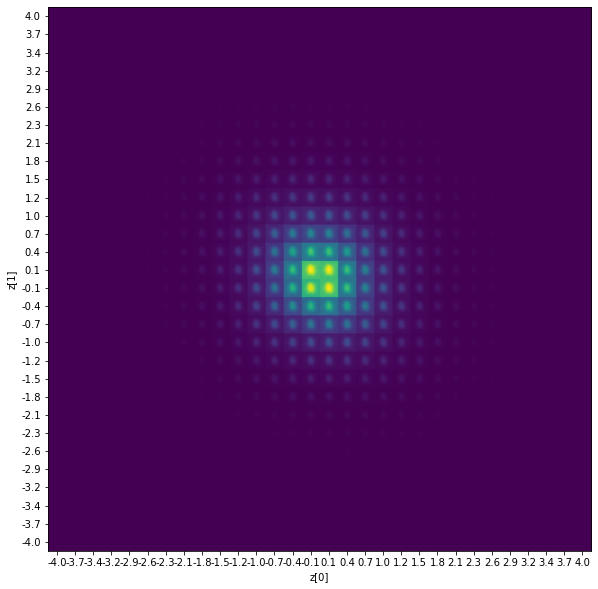

In [16]:
n = 30
digit_size = 120
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi,0,0,0]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = (n - 1) * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure)
plt.savefig(filename)
plt.show()

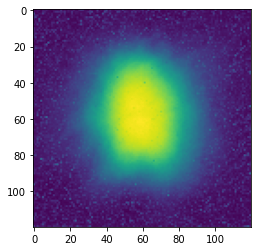

In [17]:
plt.imshow(decoder.predict(np.array([[0,0,0,0,0]])).reshape(120,120))

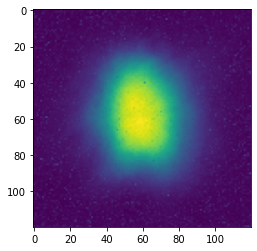

In [18]:
plt.imshow(decoder.predict(np.random.rand(5).reshape(1,5)).reshape(120,120))

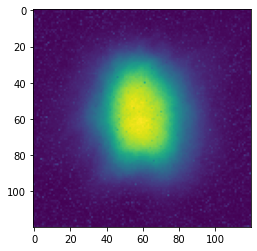

In [19]:
plt.imshow(decoder.predict(np.random.rand(5).reshape(1,5)).reshape(120,120))

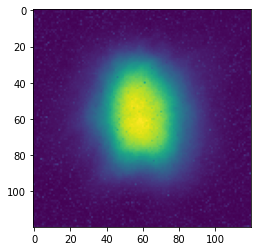

In [20]:
plt.imshow(decoder.predict(np.random.rand(5).reshape(1,5)).reshape(120,120))

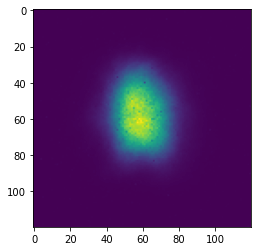

In [21]:
plt.imshow(decoder.predict(np.random.rand(5).reshape(1,5)*4).reshape(120,120))

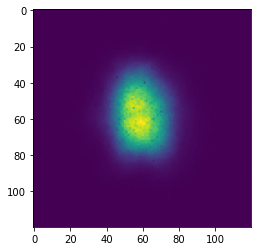

In [22]:
plt.imshow(decoder.predict(np.random.rand(5).reshape(1,5)*(-4)).reshape(120,120))

In [23]:
codes=[]
for i in range(x_train.shape[0]):
    codes_i=encoder.predict(x_train[i].reshape(1,14400))[0]
    codes.append(codes_i)

In [24]:
codes=pd.DataFrame(np.array(codes).reshape(-1,5))

In [25]:
types=manifest.drop('Name',axis=1).idxmax(axis=1)

In [26]:
types=pd.DataFrame(types)

In [27]:
result = pd.concat([types.reset_index(drop=True), codes], axis=1)

In [28]:
result

,0,0,1,2,3,4
0,Rock,0.205003,0.454066,0.453426,-0.478685,-0.450245
1,Electric,0.288344,0.641430,0.638724,-0.676928,-0.636810
2,Ghost,0.318149,0.706633,0.701182,-0.745844,-0.703167
3,Ground,0.306448,0.676655,0.664425,-0.712955,-0.674683
4,Electric,0.245642,0.545277,0.543512,-0.575420,-0.541679
...,...,...,...,...,...,...
716,Fire,0.183147,0.405198,0.403268,-0.426508,-0.402152
717,Bug,0.284819,0.633251,0.630564,-0.668815,-0.629688
718,Fire,0.058533,0.130343,0.114257,-0.135340,-0.135414
719,Water,0.333508,0.740445,0.732675,-0.781020,-0.736775


In [29]:
result.columns=['Type','latent var 1','latent var 2', 'latent var 3','latent var 4','latent var 5']

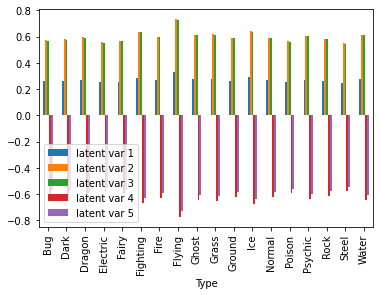

In [30]:
result.groupby('Type').median().plot(kind='bar')

In [31]:
result.groupby('Type').median().plot(kind='box')

ValueError: boxplot is not a valid plot kind